In [43]:
#!pip install ffmpeg-python --user
#!pip install autosub --user
#!pip install praat-parselmouth --user

  Using cached https://files.pythonhosted.org/packages/09/7b/9fa1172a63b6277603d27bb5613559b5a8888f58e68c1698017b87b0061d/praat_parselmouth-0.3.3-cp36-cp36m-manylinux1_x86_64.whl
You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [115]:
import wave
import audioop
import math

import parselmouth
from pydub import AudioSegment

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns

## Silence Removal

In [132]:
#- Functions were mined from Autosub (https://github.com/agermanidis/autosub/blob/master/autosub/__init__.py)

def percentile(arr, percent):
    """
    Calculate the given percentile of arr.
    """
    arr = sorted(arr)
    index = (len(arr) - 1) * percent
    floor = math.floor(index)
    ceil = math.ceil(index)
    if floor == ceil:
        return arr[int(index)]
    low_value = arr[int(floor)] * (ceil - index)
    high_value = arr[int(ceil)] * (index - floor)
    return low_value + high_value

def find_speech_regions(filename, frame_width=4096, min_region_size=0.5, max_region_size=6): # pylint: disable=too-many-locals
    """
    Perform voice activity detection on a given audio file.
    """
    reader = wave.open(filename)
    sample_width = reader.getsampwidth()
    rate = reader.getframerate()
    n_channels = reader.getnchannels()
    chunk_duration = float(frame_width) / rate

    n_chunks = int(math.ceil(reader.getnframes()*1.0 / frame_width))
    energies = []

    for _ in range(n_chunks):
        chunk = reader.readframes(frame_width)
        energies.append(audioop.rms(chunk, sample_width * n_channels))

    threshold = percentile(energies, 0.25)

    elapsed_time = 0

    regions = []
    region_start = None

    for energy in energies:
        is_silence = energy <= threshold
        max_exceeded = region_start and elapsed_time - region_start >= max_region_size

        if (max_exceeded or is_silence) and region_start:
            if elapsed_time - region_start >= min_region_size:
                regions.append((region_start, elapsed_time))
                region_start = None

        elif (not region_start) and (not is_silence):
            region_start = elapsed_time
        elapsed_time += chunk_duration
    return regions

speech_segments = find_speech_regions('./files/harvard16bit.wav')

In [133]:
sound = AudioSegment.from_wav("./files/harvard16bit.wav")
sound

In [134]:
silence_removed = AudioSegment.silent(duration=1)

for seg in speech_segments:
    start = seg[0]*1000
    end = seg[1]*1000
    
    silence_removed += sound[start:end]

silence_removed.export("./files/silence_removed.wav", format="wav")
silence_removed

### Plotting Soundwaves

In [135]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

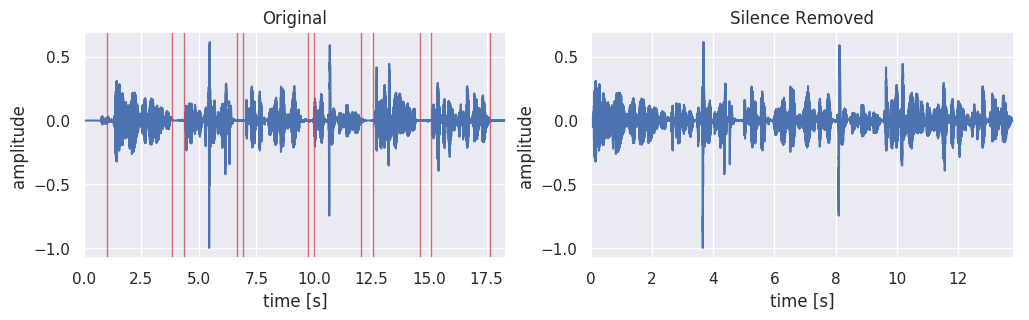

In [136]:
snd = parselmouth.Sound("./files/harvard16bit.wav")
sil_rm = parselmouth.Sound("./files/silence_removed.wav")

f, axes = plt.subplots(1, 2, figsize=(12,3))



plt.subplot(1,2,1)
plt.plot(snd.xs(), snd.values.T)

for xv in flat_segments:
    plt.axvline(x=xv, linewidth=1, color='r', alpha=0.8)

plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.title('Original')

plt.subplot(1,2,2)
plt.plot(sil_rm.xs(), sil_rm.values.T)
plt.xlim([sil_rm.xmin, sil_rm.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.title('Silence Removed')

plt.show()

## Speech Recognition of Segments